# Recurrent Neural Network (LSTM Implementation)

##Data Preprocessing

### Importing the libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Importing the training set

In [ ]:
dataset_train = pd.read_csv('Google_Stock_Price_Train.csv')
training_set = dataset_train.iloc[:, 1:2].values    #we did 1:2 since we need a numpy array

### Feature Scaling

In [ ]:
# normalization is better than standardization in case of RNNs

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))    # 0,1 as after normalization the range of values will be between them
training_set_scaled = sc.fit_transform(training_set)   # we added a new variable for scaled data since we require the original data too

### Creating a data structure with 60 timesteps and 1 output

In [ ]:
# the datastructure tells which data will be needed to be remember by the RNN
# 60 timestamps means the RNN will store the data for last 60 days to predict next price
# the 60 came from trial and error for best results

X_train = []   #store the data for last 60 days in these arrays
y_train = []
for i in range(60, 1258):  # (60, total number of rows) = len(training_set)
  X_train.append(training_set_scaled[i-60:i, 0])
  y_train.append(training_set_scaled[i, 0])      # y_train includes values after 60 days (predicted data!)

X_train = np.array(X_train)  # we need our data as numpy array, not as list
y_train = np.array(y_train)

In [ ]:
print(X_train.shape)   # each row contains 60 values which corresponds to previous data
                       # y_train consists of value 'based on' the 60 values 

(1198, 60)


### Reshaping

In [ ]:
# we need more indicators for predicition
# right now we only have one indicator (open value)

# inputs: A 3D tensor with shape [batch_size, timesteps, number_of_new_features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
print(X_train.shape)

(1198, 60, 1)


## Building and Training the RNN

### Importing the Keras libraries and packages

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Initialising the RNN

In [ ]:
regressor = Sequential()  # regressor is now a sequence of layers
                          # 'regressor' because we are regressing price

### Adding the first LSTM layer and some Dropout regularisation

In [ ]:
# Dropout regularization is used to prevent overfitting == model which is very good for the test data but fails for test data

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))

# we need high amount of units to increase the dimensionality as stock price prediction is quite comples
# return sequences has to be true since it needs to be a stacked layer, when its not it will be false
# input_shape is the shape of input data (3D). However we only need to add the last 2 dimensions, first one is automatically taken care of

regressor.add(Dropout(0.2))
# it means that 20% of the neurons(i.e. 10 neurons) will be dropped during the training

### Adding a second LSTM layer and some Dropout regularisation

In [ ]:
regressor.add(LSTM(units = 50, return_sequences = True))  # we dont need to indicate the input shape in next layers
regressor.add(Dropout(0.2))

### Adding a third LSTM layer and some Dropout regularisation

In [ ]:
regressor.add(LSTM(units = 50, return_sequences = True)) # return_sequences is still true since there still another layer after it
regressor.add(Dropout(0.2))

### Adding a fourth LSTM layer and some Dropout regularisation

In [ ]:
regressor.add(LSTM(units = 50)) # return_sequences is now false, which is by default
regressor.add(Dropout(0.2))

### Adding the output layer

In [ ]:
regressor.add(Dense(units = 1))
# we are using the Dense class as the output layer as this layer is fully connected layer
# units = 1, since we need one output

### Compiling the RNN

In [ ]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# optimizer can be RMSProp too however adam is fine
# loss needs to be mean squared error as we are regressing.

### Fitting the RNN to the Training set

In [ ]:
regressor.fit(X_train, y_train, batch_size = 32, epochs = 100)

Epoch 1/100
1198/1198 [==============================] - 7s 6ms/step - loss: 0.0332
Epoch 2/100
1198/1198 [==============================] - 5s 4ms/step - loss: 0.0071
Epoch 3/100
1198/1198 [==============================] - 5s 4ms/step - loss: 0.0054
Epoch 4/100
1198/1198 [==============================] - 5s 5ms/step - loss: 0.0048
Epoch 5/100
1198/1198 [==============================] - 5s 5ms/step - loss: 0.0049
Epoch 6/100
1198/1198 [==============================] - 5s 4ms/step - loss: 0.0050
Epoch 7/100
1198/1198 [==============================] - 5s 5ms/step - loss: 0.0044
Epoch 8/100
1198/1198 [==============================] - 5s 5ms/step - loss: 0.0046
Epoch 9/100
1198/1198 [==============================] - 5s 5ms/step - loss: 0.0048
Epoch 10/100
1198/1198 [==============================] - 5s 5ms/step - loss: 0.0044
Epoch 11/100
1198/1198 [==============================] - 5s 5ms/step - loss: 0.0043
Epoch 12/100
1198/1198 [==============================] - 5s 5ms/step - lo

## Making the predictions and visualising the results

### Getting the real stock price of 2017

In [ ]:
dataset_test = pd.read_csv('Google_Stock_Price_Test.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values

### Getting the predicted stock price of 2017

In [ ]:
# the model is configured so that it takes the last 60 days(3 months) of data to outcome the prediction
# so to get prediction for 2017 we need the data for 2016 as well as some data of 2017
# thats why we need to concatenate the test and train data
# we will need to concatenate the train dataset and the train dataset and then scale them

dataset_total = pd.concat((dataset_train["Open"], dataset_test["Open"]), axis = 0)

# train data before test data
# we only need to concatenate the "Open" column
# axis = 0 --> vertical concatenate i.e adding rows
# axis = 1 --> horizontal concatenat i.e adding columns

In [ ]:
# total - test is the last date of train
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60 : ].values 

In [ ]:
# we didnt use the iloc method and therefore we need to make this list a numpy array
inputs = inputs.reshape(-1,1)   # -1 means its taken as the length of the original array, and the other dimension we kept as 1

In [ ]:
# now we need to correct the format of the data i.e. 3D format
# but first we need to scale the data (remember!!)

inputs = sc.transform(inputs)  # note: we are not fitting again

In [ ]:
# now we will correct the format of the data so that it can be fed into the rnn
X_test = []

for i in range(60, 80):  # 60, 60+20
  X_test.append(inputs[i-60:i, 0])

X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# now we do the prediction

predicted_stock_price = regressor.predict(X_test)

In [ ]:
# note: now we need to inverse transform to get the pridicted stock price at right scale

predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [ ]:
print(predicted_stock_price)

### Visualising the results

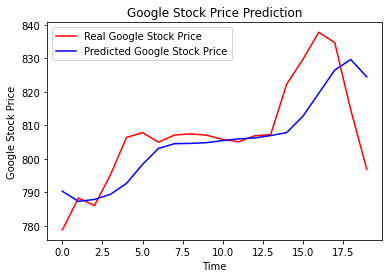

In [ ]:
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

In [ ]:
# the model is laggig a bit since the changes in the stock price is rapid non-linear changes
# such as the spikes
# however the model reacts well to the smooth changes.

In [ ]:
# accuracy of the model
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print(rmse/800)  # relative error
print(rmse)     # absolute error

0.013576020728310769
10.860816582648615
